# Example : Interrupted Time Series (InterruptedTimeSeries) with `pymc` models when the treatment time is unknown

This notebook showcases a new feature of the ``InterruptedTimeSeries`` class in CausalPy : it now supports models that can infer the treatment time directly from the data.

We illustrate this using a built-in model from the CausalPy library, which only requires specifying the effect of the intervention. From this, the model estimates when the intervention likely occurred.

In [1]:
# Imports ...

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

### Using the `InterventionTimeEstimator` PyMC model

The ``InterventionTimeEstimator`` (``InterventionTimeEstimator``) model is built to infer *when* an intervention likely occurred, based on the **type of effect** you expect it to have caused.

You don’t specify the time of the change. Instead, you specify InterruptedTimeSeries *form*: a sudden jump (``level``), a gradual shift (``trend``), or a short-lived anomaly (``impulse``). Optionally, you can narrow the search by providing a plausible time range.

The model then scans through time, comparing candidate intervention points and estimating how well each one explains the data, all through Bayesian inference.

#### Example 1 : Level Change

In this example, we apply the ``InterventionTimeEstimator`` model in InterruptedTimeSeries simplest form to a time series with a **level change**.

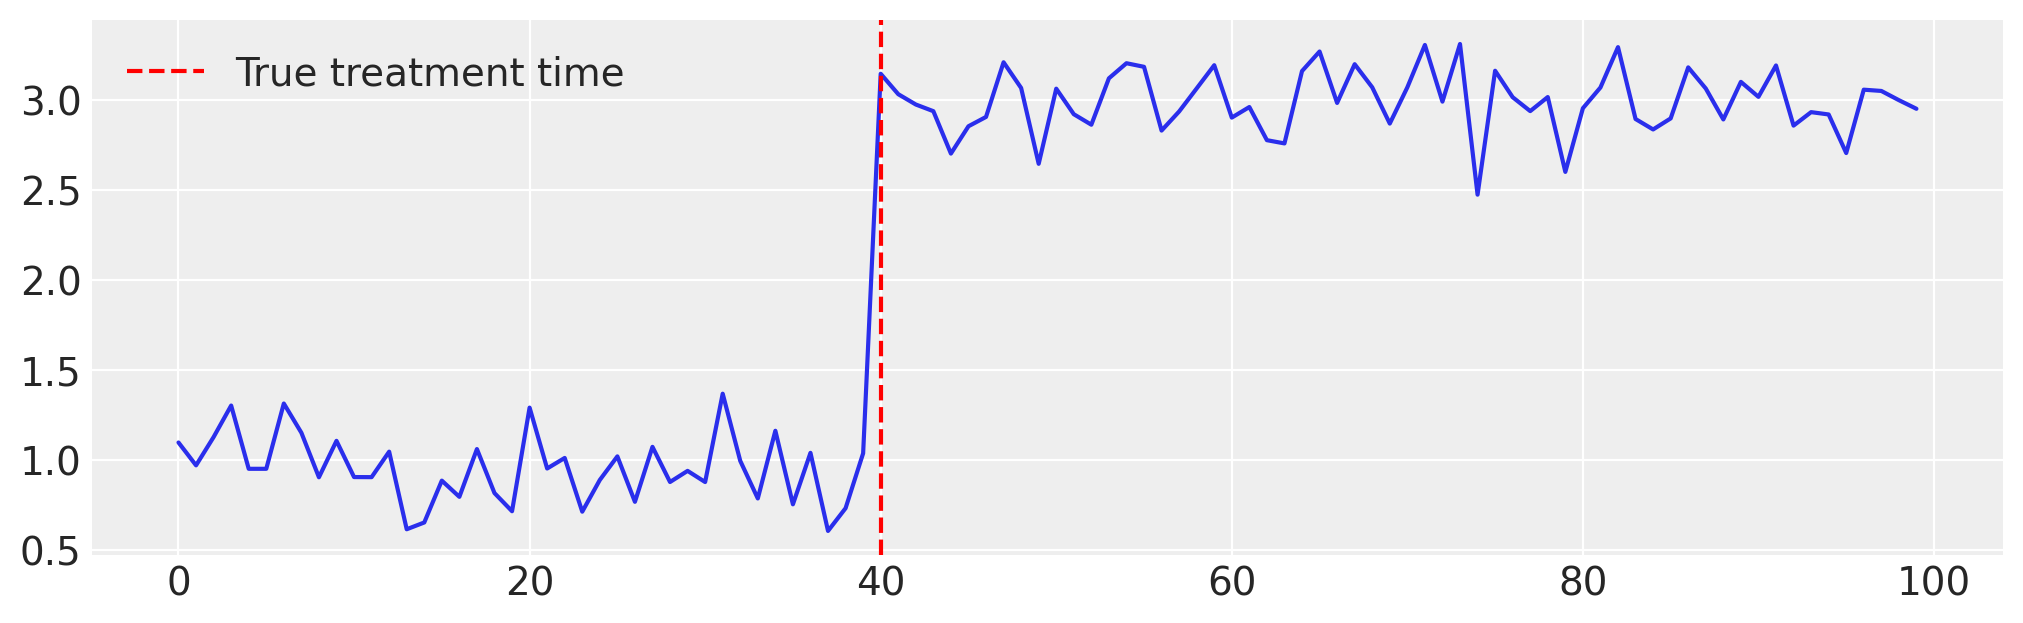

In [3]:
# Generate the Data ...
np.random.seed(seed)

n = 100
tau_true = 40
x = np.arange(n)
y = np.where(x >= tau_true, 2, 0.0) + np.random.normal(1, 0.2, size=n)
df = pd.DataFrame({"t": x, "y": y})

plt.figure(figsize=(10, 3))
plt.plot(x, y)
plt.axvline(tau_true, color="red", linestyle="--", label="True treatment time")
plt.legend()

Now, when initializing the InterventionTimeEstimator model, we only need to :
- Ensure that InterruptedTimeSeries ``treatment_type_effect`` includes the key ``"level"``.
- Specify which variable in the formula represents time, so that the model can correctly track the temporal progression between predictions.

After that, the model can be used as is with the ``InterruptedTimeSeries`` class by setting the ``treatment_time`` parameter to ``None``.

In [4]:
from causalpy.experiments.interrupted_time_series import InterruptedTimeSeries
from causalpy.pymc_models import InterventionTimeEstimator

model = InterventionTimeEstimator(
    time_variable_name="t",
    treatment_type_effect={"level": []},
    sample_kwargs={"sample_seed": seed},
)

result = InterruptedTimeSeries(
    data=df,
    treatment_time=None,
    formula="y ~ 1 + t",
    model=model,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [treatment_time, beta, level, sigma, y_hat]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
Sampling: [beta, level, sigma, treatment_time, y_hat, y_ts]
Sampling: [y_ts]
Sampling: [y_hat, y_ts]
Sampling: [y_hat, y_ts]


Finally, this example produces two plots.

The first displays three graphs: 
- the **model’s predictions**, showing both the fitted curve *with* and *without* the inferred causal effect, 
- the **estimated causal impact** which isolates the effect by removing it from the predictions,
- and the **cumulative impact over time**.

The second plot shows the posterior distribution of the inferred treatment time.

:::{note} that the R² score is computed using the full predictions — that is, including the causal effect. In contrast, the causal impact is calculated by subtracting the estimated effect from the predictions.:::

(<Figure size 700x800 with 3 Axes>,
 array([<Axes: title={'center': '\n            Pre-intervention Bayesian $R^2$: 0.95\n            (std = 0.0027)\n            '}>,
        <Axes: title={'center': 'Causal Impact'}>,
        <Axes: title={'center': 'Cumulative Causal Impact'}>], dtype=object))

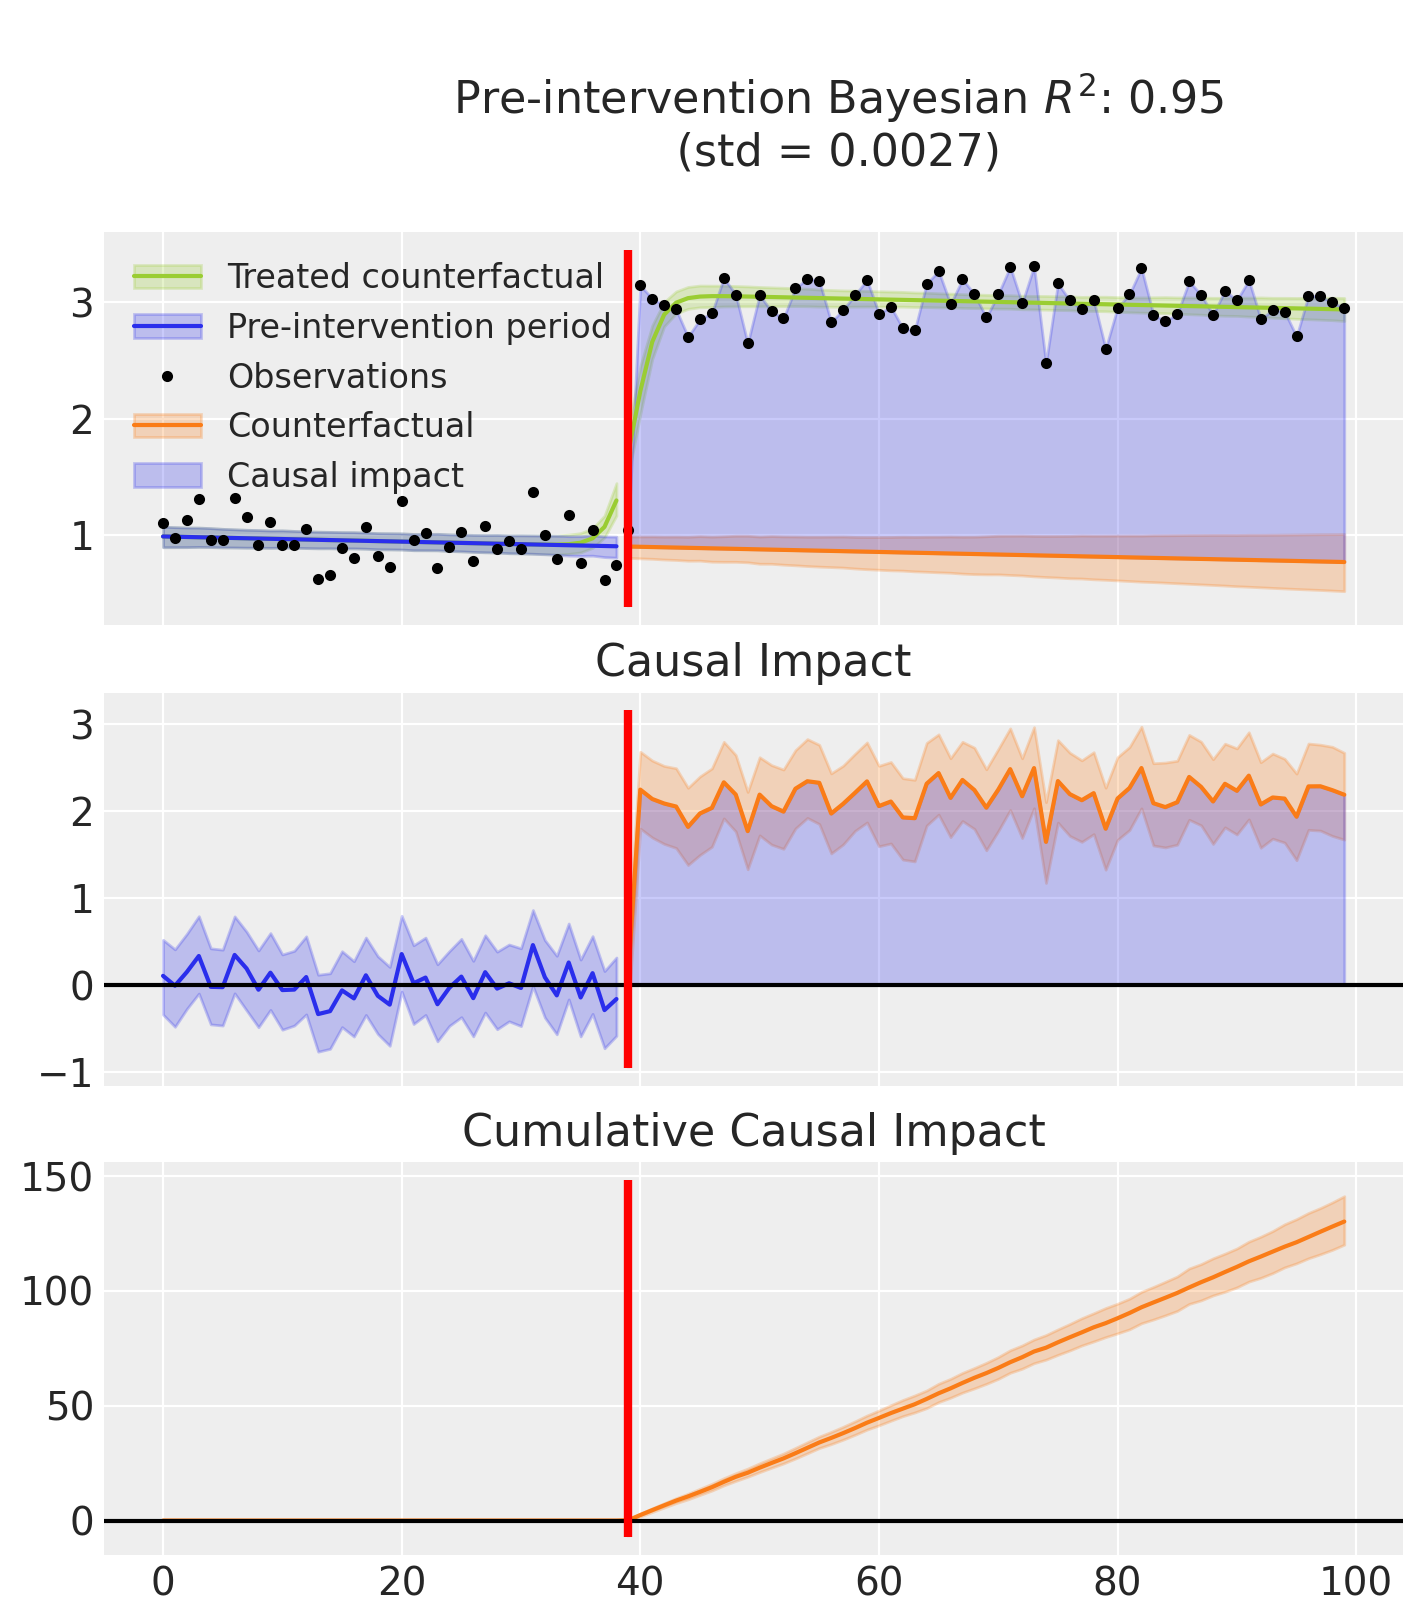

In [5]:
result.plot()

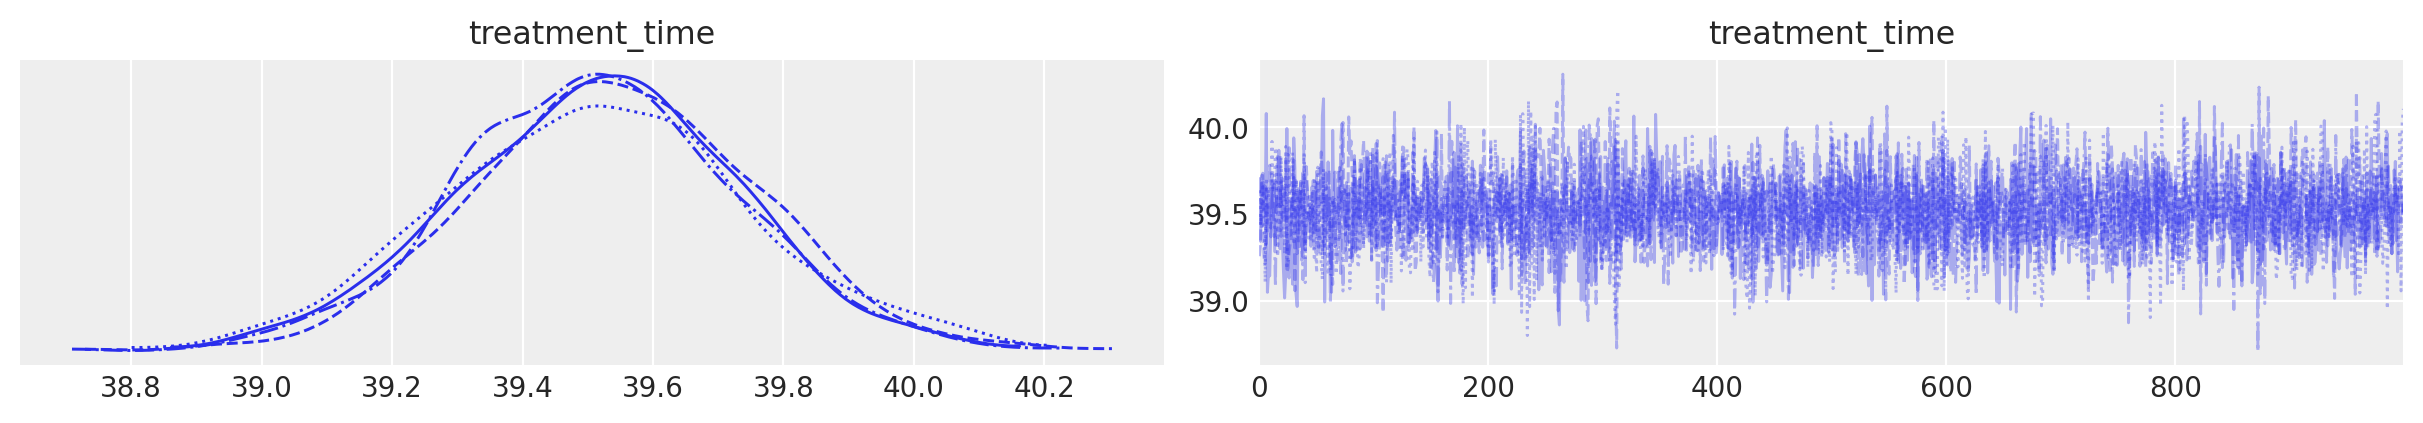

In [6]:
result.plot_treatment_time()

#### Example 2 : Trend Change

In this example, we'll showcase how to use the InterventionTimeEstimator when the time series exhibInterruptedTimeSeries a **trend change**.

C:\Users\jeanv\AppData\Local\Temp\ipykernel_2092\1876234472.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


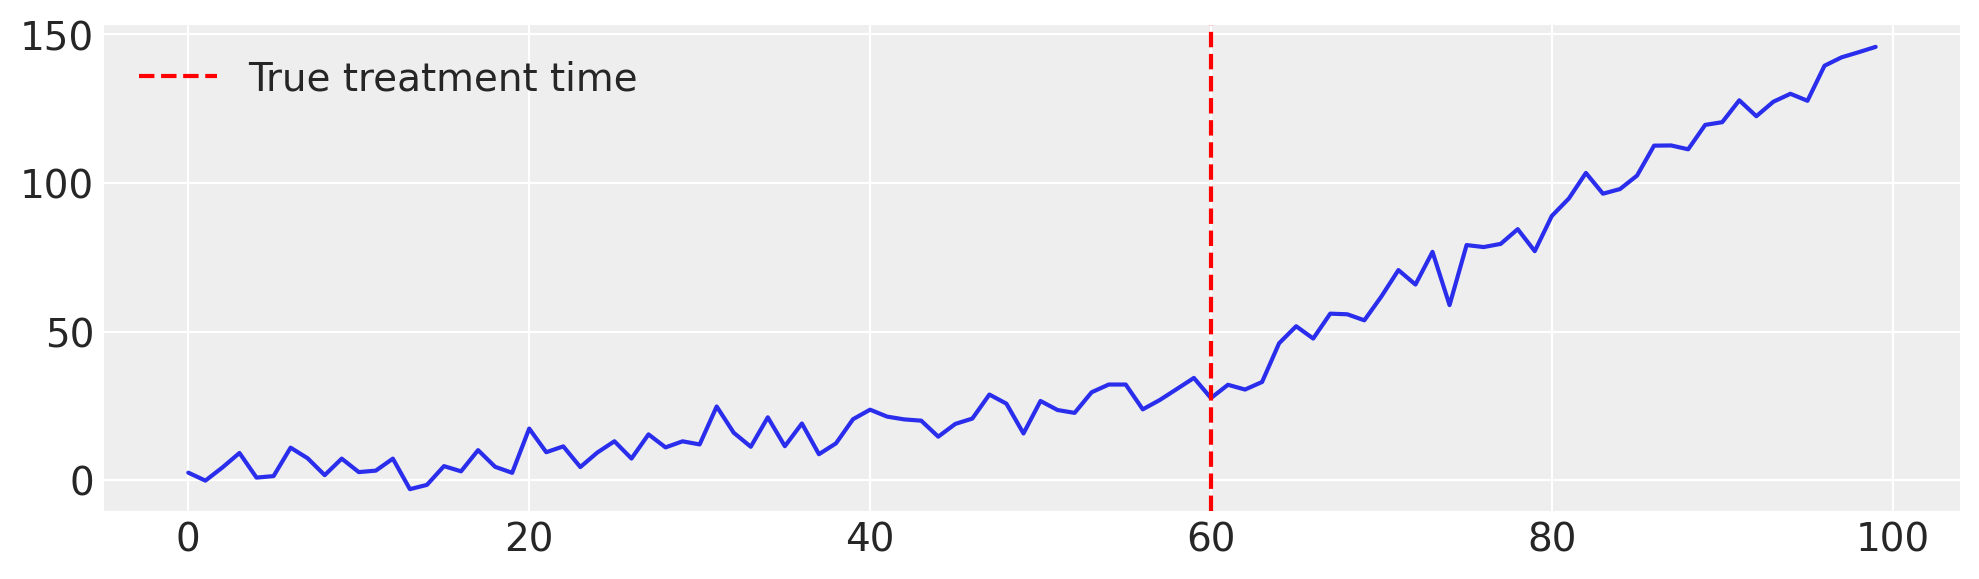

In [7]:
# Generate the data ...
# Set random seed for reproducibility
np.random.seed(42)

n = 100
intervention_point = 60
time = np.arange(n)

pre_trend = 0.5 * time[:intervention_point] + np.random.normal(
    scale=5, size=intervention_point
)
post_trend = (
    0.5 * time[intervention_point]
    + 3.0 * (time[intervention_point:] - time[intervention_point])
    + np.random.normal(scale=5, size=n - intervention_point)
)

synthetic_series = np.concatenate([pre_trend, post_trend])

# Create DataFrame
df = pd.DataFrame({"time": time, "y": synthetic_series})

# Plot
plt.figure(figsize=(10, 3))
plt.plot(df["time"], df["y"])
plt.axvline(
    x=intervention_point, color="red", linestyle="--", label="True treatment time"
)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Compared to the previous example, the only changes are:
- The time column is now named ``"time"``, requiring an update to the time_variable_name parameter.
- We use ``"trend"`` instead of ``"level"`` for the ``treatment_type_effect``, to model a change in slope rather than a level shift.

In [8]:
model = InterventionTimeEstimator(
    time_variable_name="time",
    treatment_type_effect={"trend": []},
    sample_kwargs={"sample_seed": seed},
)

result = InterruptedTimeSeries(
    data=df,
    treatment_time=None,
    formula="y ~ 1 + time",
    model=model,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [treatment_time, beta, trend, sigma, y_hat]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
Sampling: [beta, sigma, treatment_time, trend, y_hat, y_ts]
Sampling: [y_ts]
Sampling: [y_hat, y_ts]
Sampling: [y_hat, y_ts]


[autoreload of cutils_ext failed: Traceback (most recent call last):
  File "c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\IPython\extensions\autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\IPython\extensions\autoreload.py", line 483, in superreload
    module = reload(module)
  File "c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\importlib\__init__.py", line 128, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'cutils_ext'
]


(<Figure size 700x800 with 3 Axes>,
 array([<Axes: title={'center': '\n            Pre-intervention Bayesian $R^2$: 0.99\n            (std = 0.00039)\n            '}>,
        <Axes: title={'center': 'Causal Impact'}>,
        <Axes: title={'center': 'Cumulative Causal Impact'}>], dtype=object))

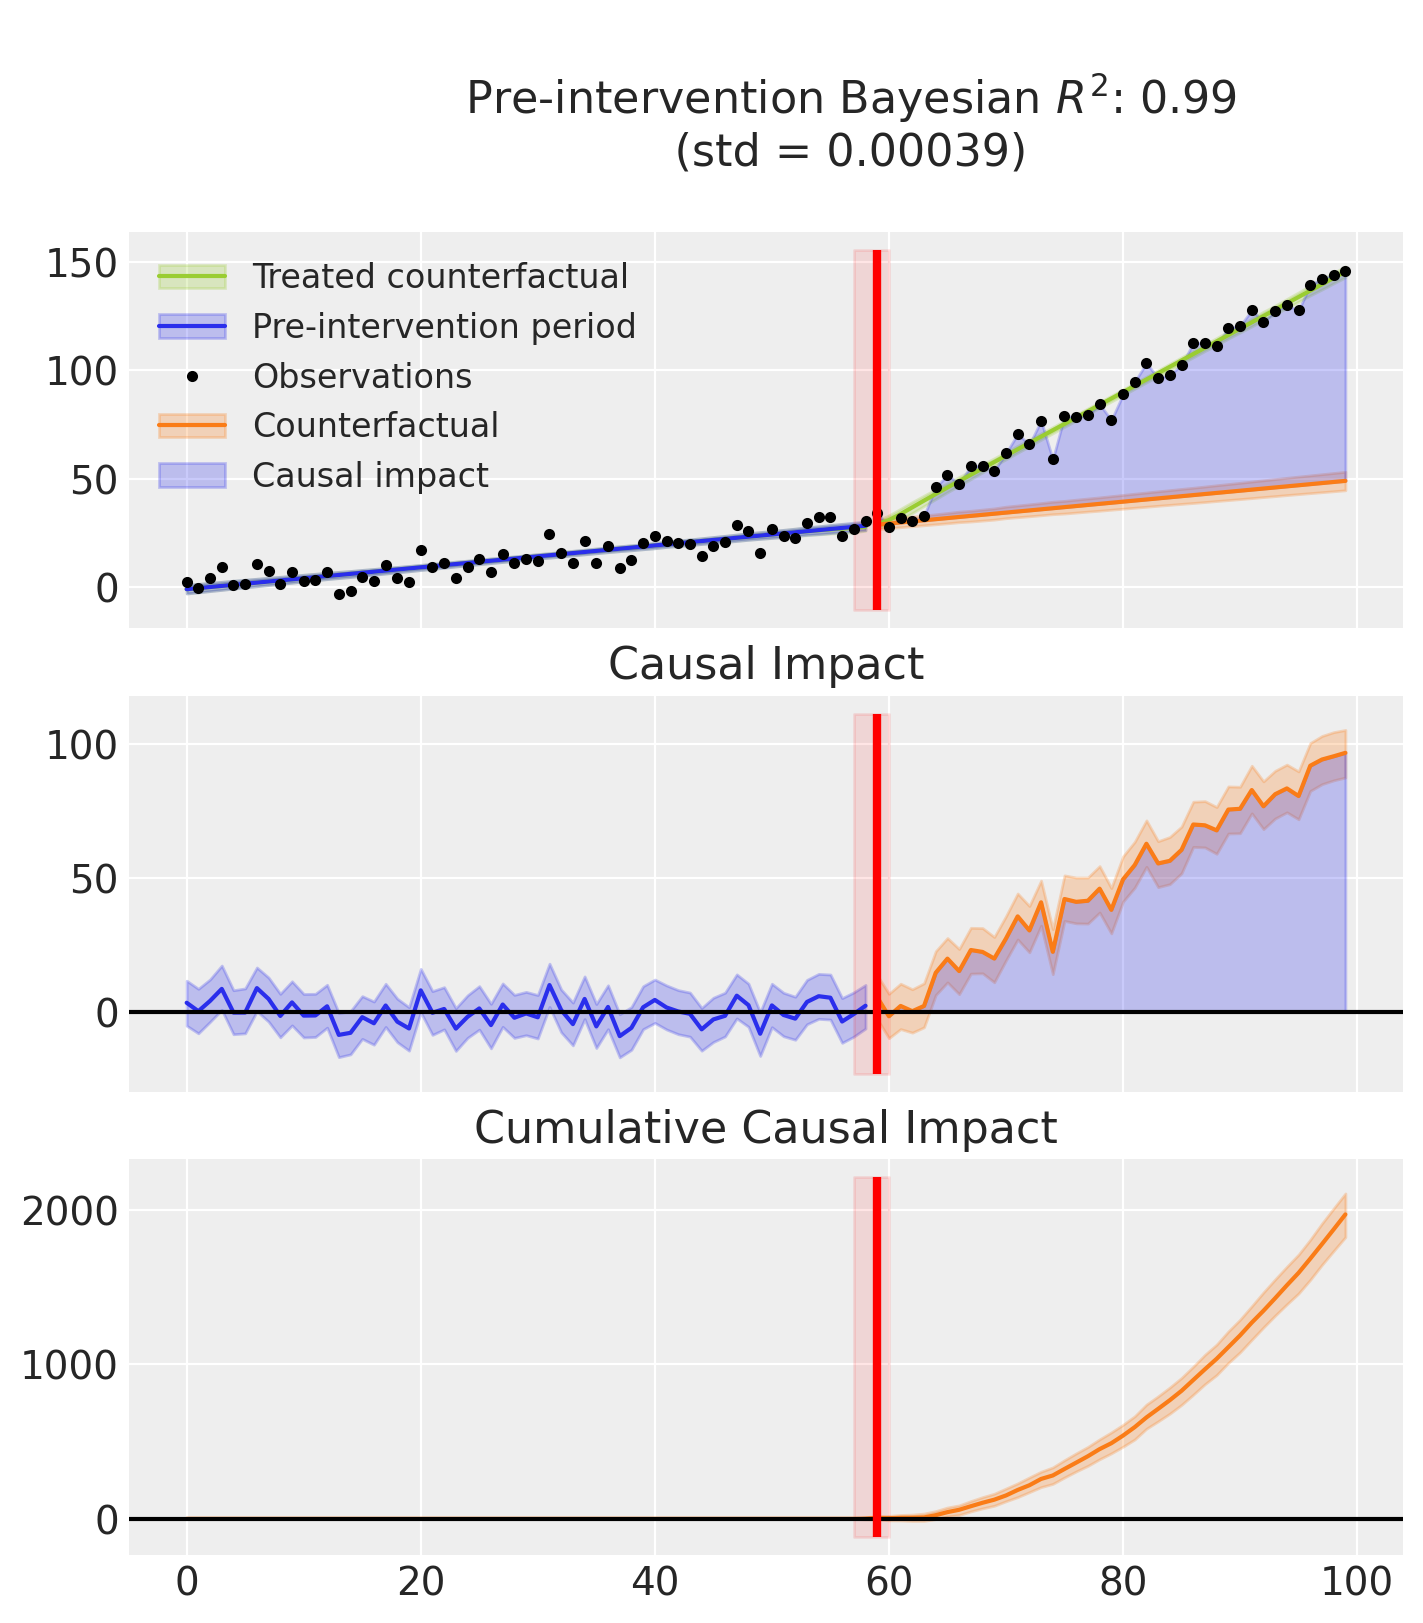

In [9]:
result.plot()

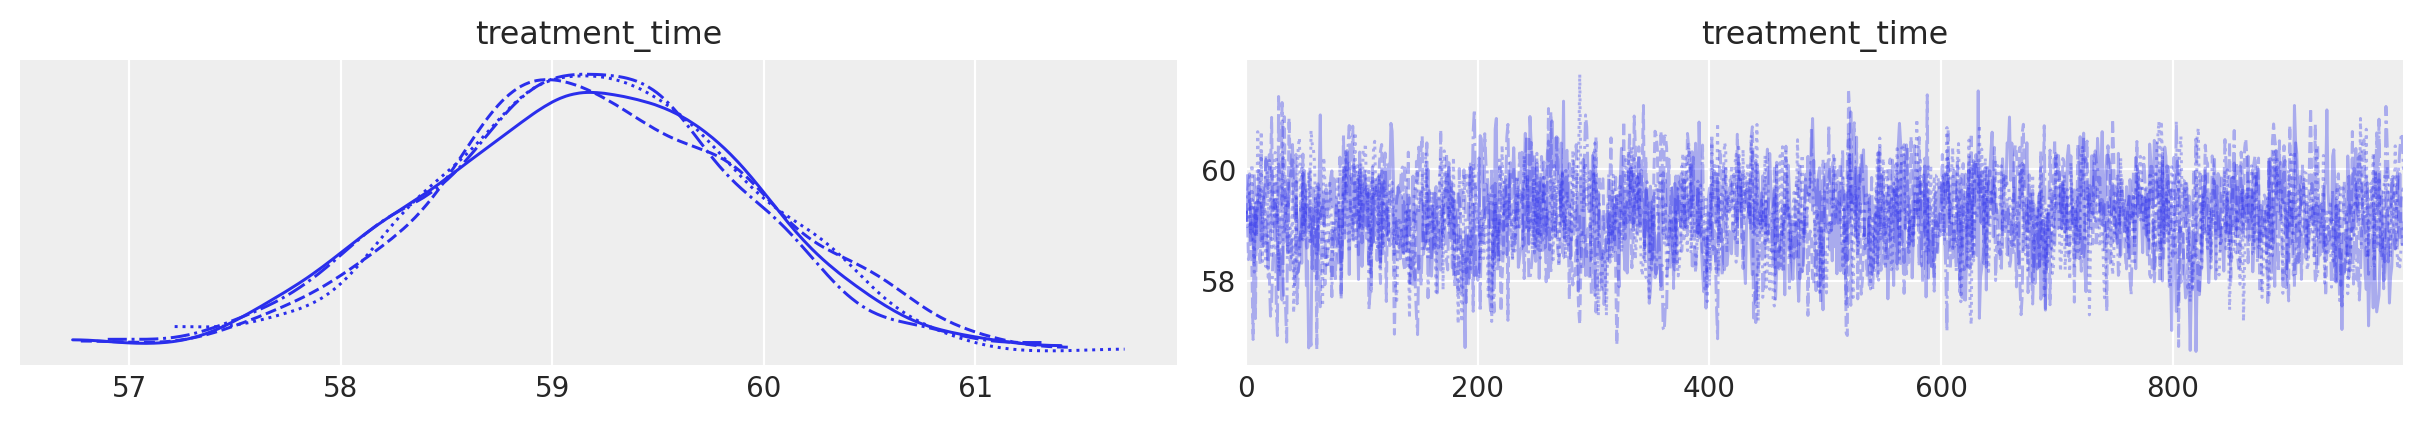

In [10]:
result.plot_treatment_time()

#### Example 3 : Impulse

In this final example, we'll demonstrate how to apply the InterventionTimeEstimator model to data that display an impulse-like effect.

C:\Users\jeanv\AppData\Local\Temp\ipykernel_2092\555926483.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


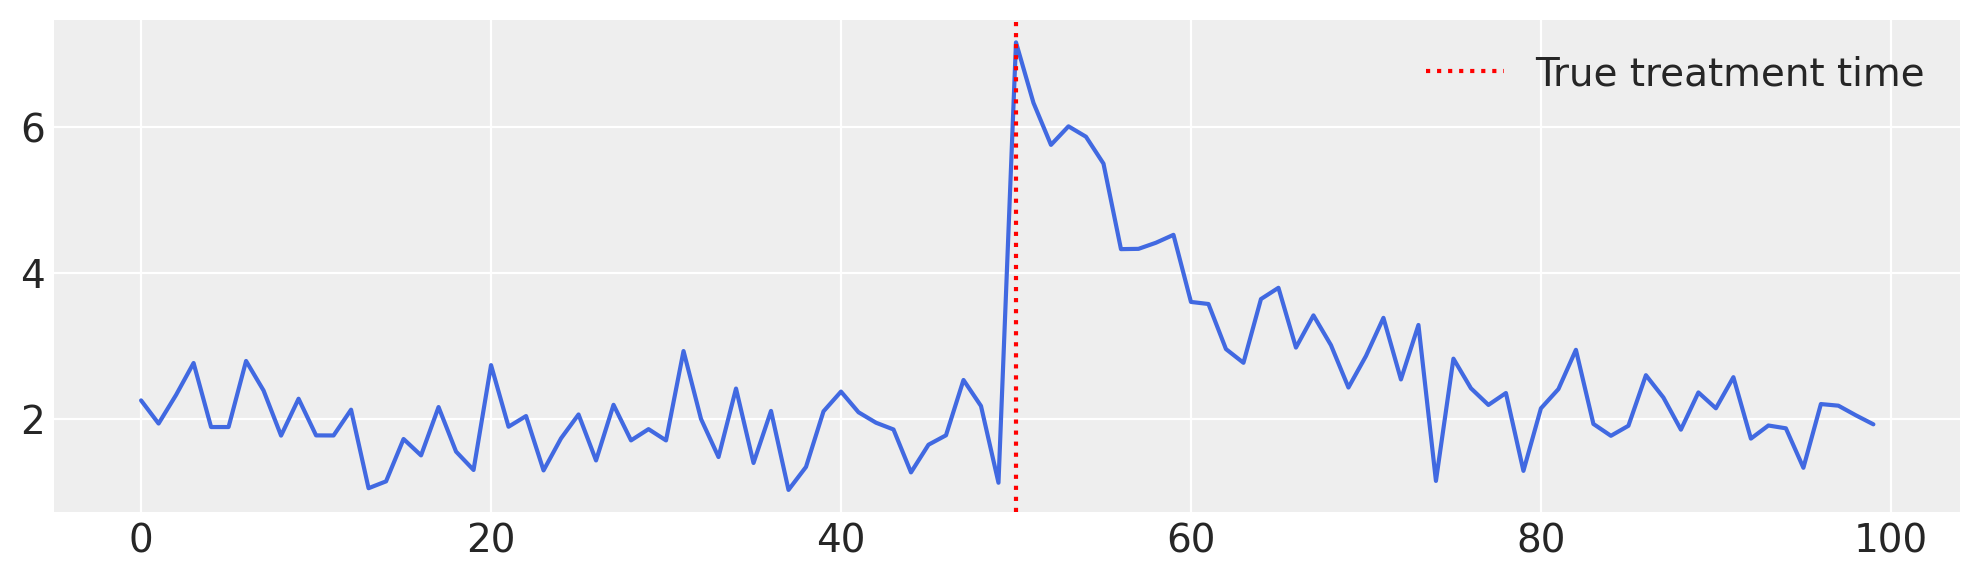

In [11]:
# Generate data ...

np.random.seed(42)
n = 100
t = np.arange(n)

intercept = 2
trend = intercept

# Impulse parameters
t0 = 50
A = 5
decay_rate = 0.1
impulse = np.zeros(n)
impulse[t0:] = A * np.exp(-decay_rate * (t[t0:] - t0))

# Bruit
noise = np.random.normal(0, 0.5, size=n)

# Série finale
y = trend + impulse + noise

df = pd.DataFrame({"y": y, "time": t})

# Plot ...

plt.figure(figsize=(10, 3))
plt.plot(t, y, color="royalblue")
plt.axvline(t0, color="red", linestyle=":", label="True treatment time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Remember to set ``treatment_type_effect`` to ``"impulse"``.

In [12]:
model = InterventionTimeEstimator(
    time_variable_name="time",
    treatment_type_effect={"impulse": []},
    sample_kwargs={"sample_seed": seed},
)

result = InterruptedTimeSeries(
    data=df,
    treatment_time=None,
    formula="y ~ 1 + time",
    model=model,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [treatment_time, beta, impulse_amplitude, decay_rate, sigma, y_hat]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
Sampling: [beta, decay_rate, impulse_amplitude, sigma, treatment_time, y_hat, y_ts]
Sampling: [y_ts]
Sampling: [y_hat, y_ts]
Sampling: [y_hat, y_ts]


[autoreload of cutils_ext failed: Traceback (most recent call last):
  File "c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\IPython\extensions\autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\IPython\extensions\autoreload.py", line 483, in superreload
    module = reload(module)
  File "c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\importlib\__init__.py", line 128, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'cutils_ext'
]


(<Figure size 700x800 with 3 Axes>,
 array([<Axes: title={'center': '\n            Pre-intervention Bayesian $R^2$: 0.78\n            (std = 0.021)\n            '}>,
        <Axes: title={'center': 'Causal Impact'}>,
        <Axes: title={'center': 'Cumulative Causal Impact'}>], dtype=object))

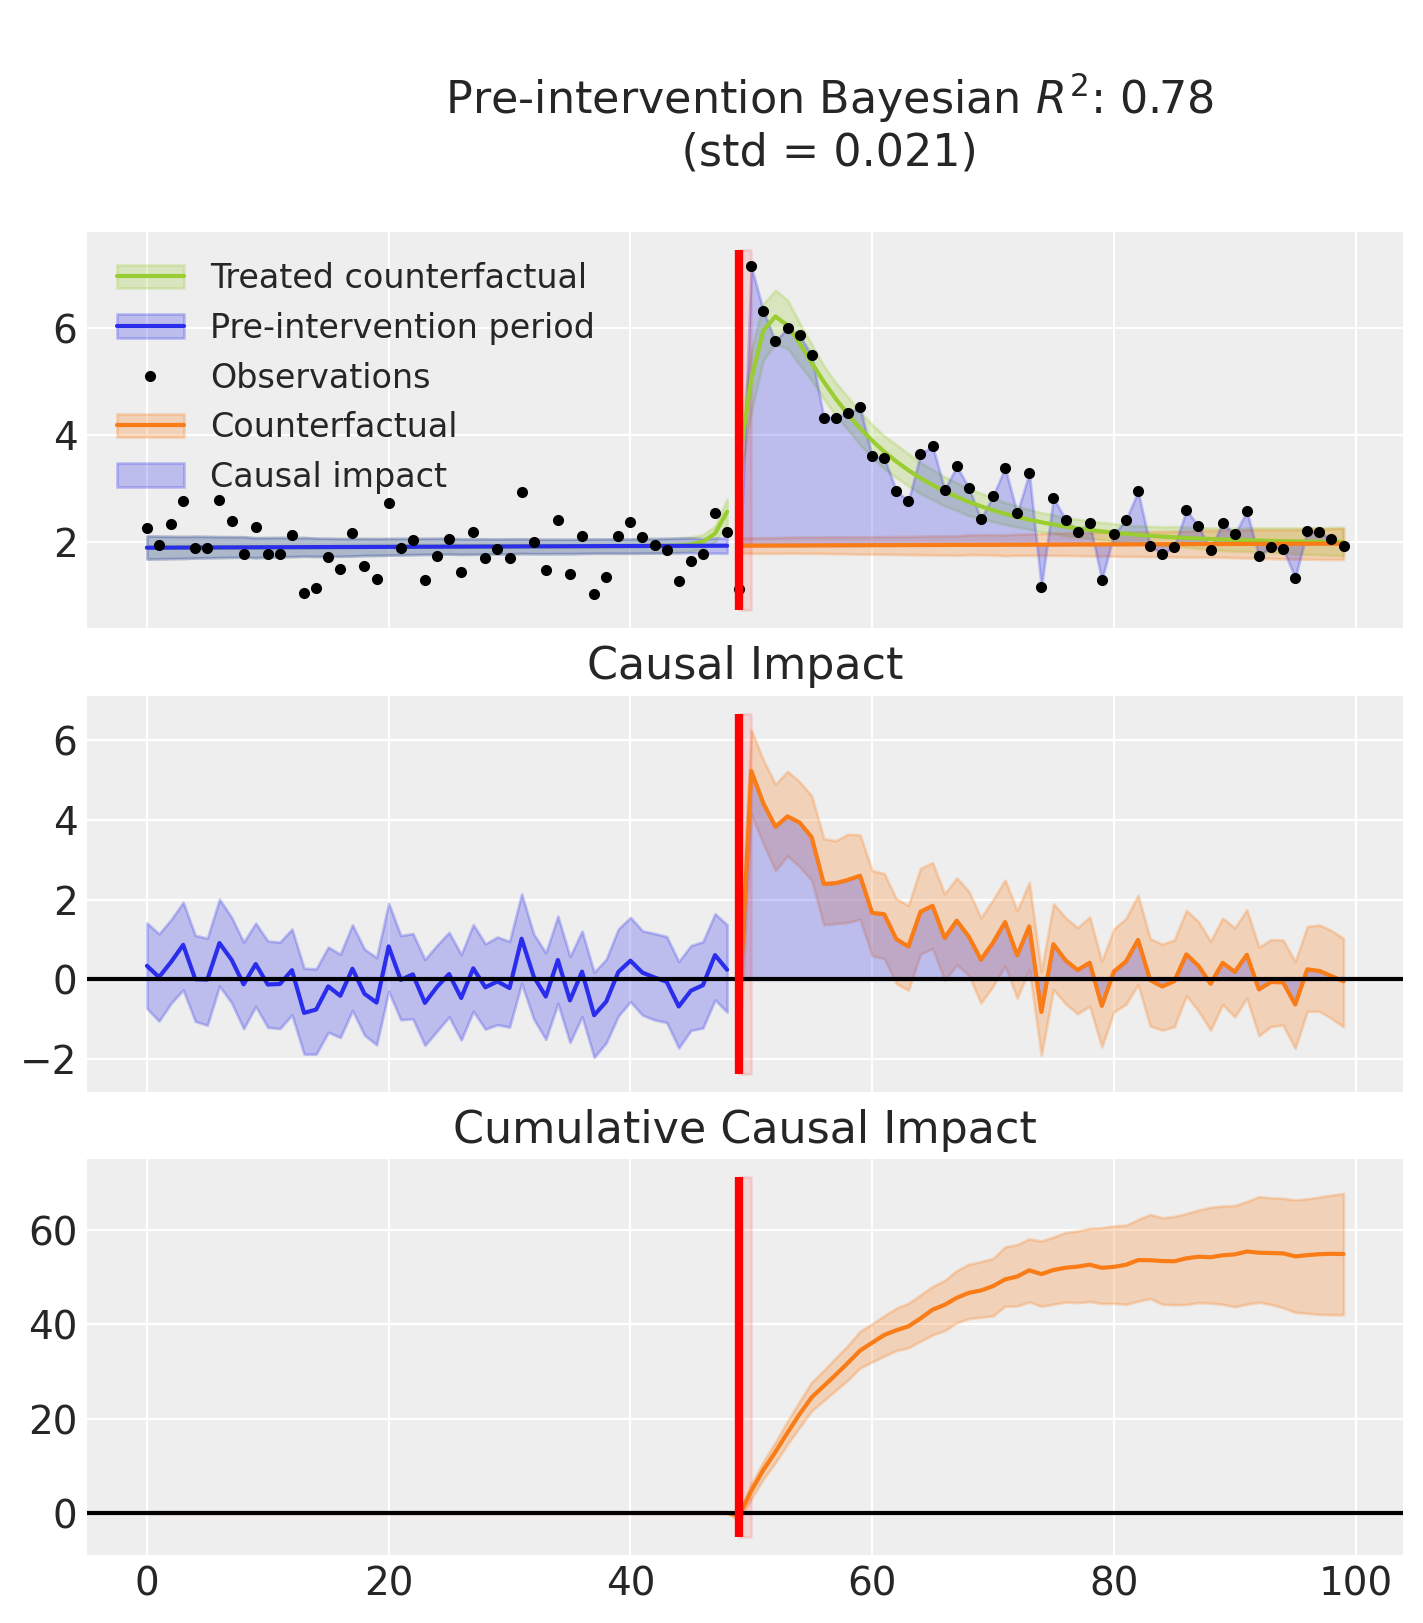

In [13]:
result.plot()

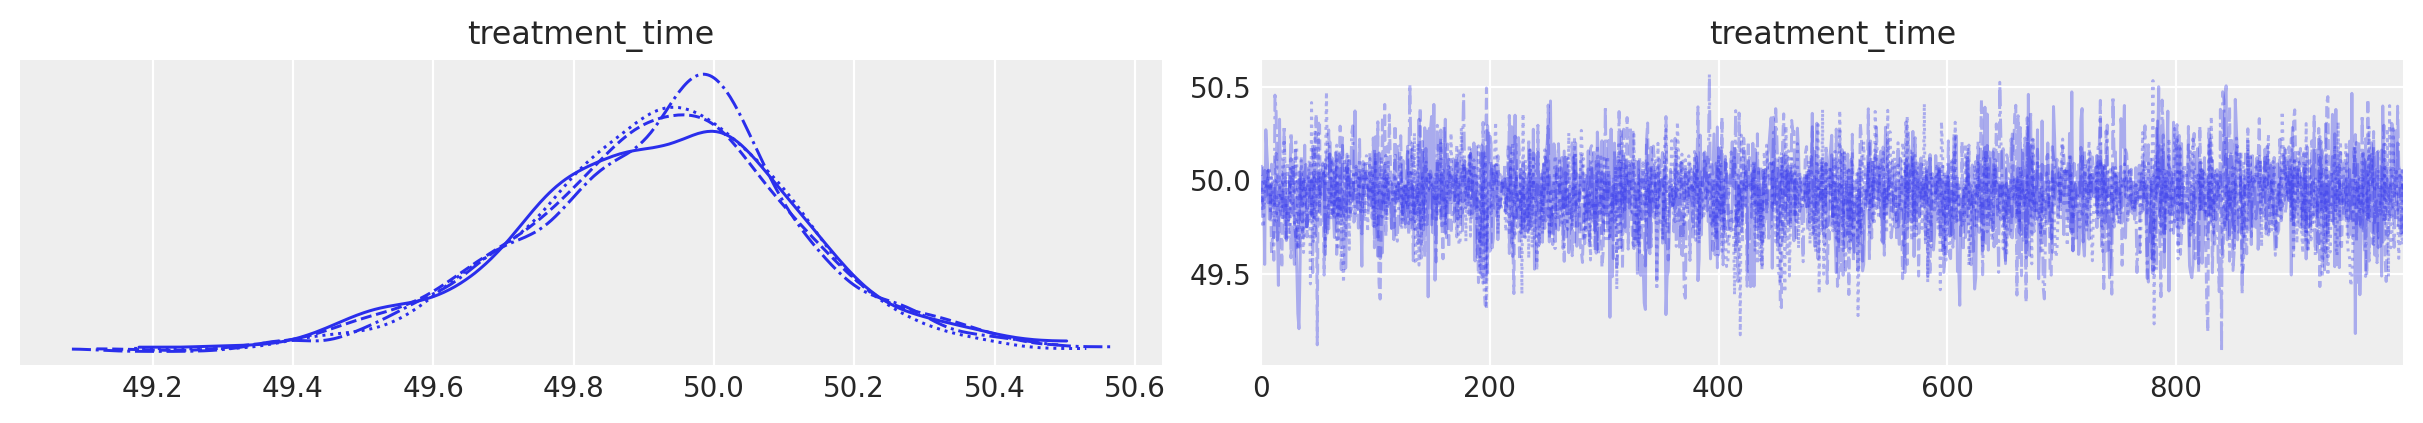

In [14]:
result.plot_treatment_time()

#### Narrowing the Inference Window

Instead of specifying a treatment_time, you can constrain the inference window by passing a time_range=(start, end) argument, where start and end correspond to the row indices or timestamps of your dataframe:

- `time_range=(80,100)`

or

- `time_range=(pd.to_datetime("2016-01-31"),pd.to_datetime("2018-01-31"))`

This can significantly improve inference speed and robustness, especially when dealing with long or noisy time series.

:::{tip}
If you’re unsure about the intervention period, try starting with ``time_range=None`` and inspect the posterior.
:::

Keeping the same example, if we now increase the noise in the data and reduce the level change, the advantage of using a restricted time_range becomes evident:

In [15]:
# Making the example

n = 100
tau_true = 40
x = np.arange(n)
y = np.where(x >= tau_true, 1.60, 0.0) + np.random.normal(1.25, 1, size=n)
df = pd.DataFrame({"t": x, "y": y})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [treatment_time, beta, level, sigma, y_hat]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
Sampling: [beta, level, sigma, treatment_time, y_hat, y_ts]
Sampling: [y_ts]
Sampling: [y_hat, y_ts]
Sampling: [y_hat, y_ts]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [treatment_time, beta, level, sigma, y_hat]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta, level, sigma, treatment_time, y_hat, y_ts]
Sampling: [y_ts]
Sampling: [y_hat, y_ts]
Sampling: [y_hat, y_ts]


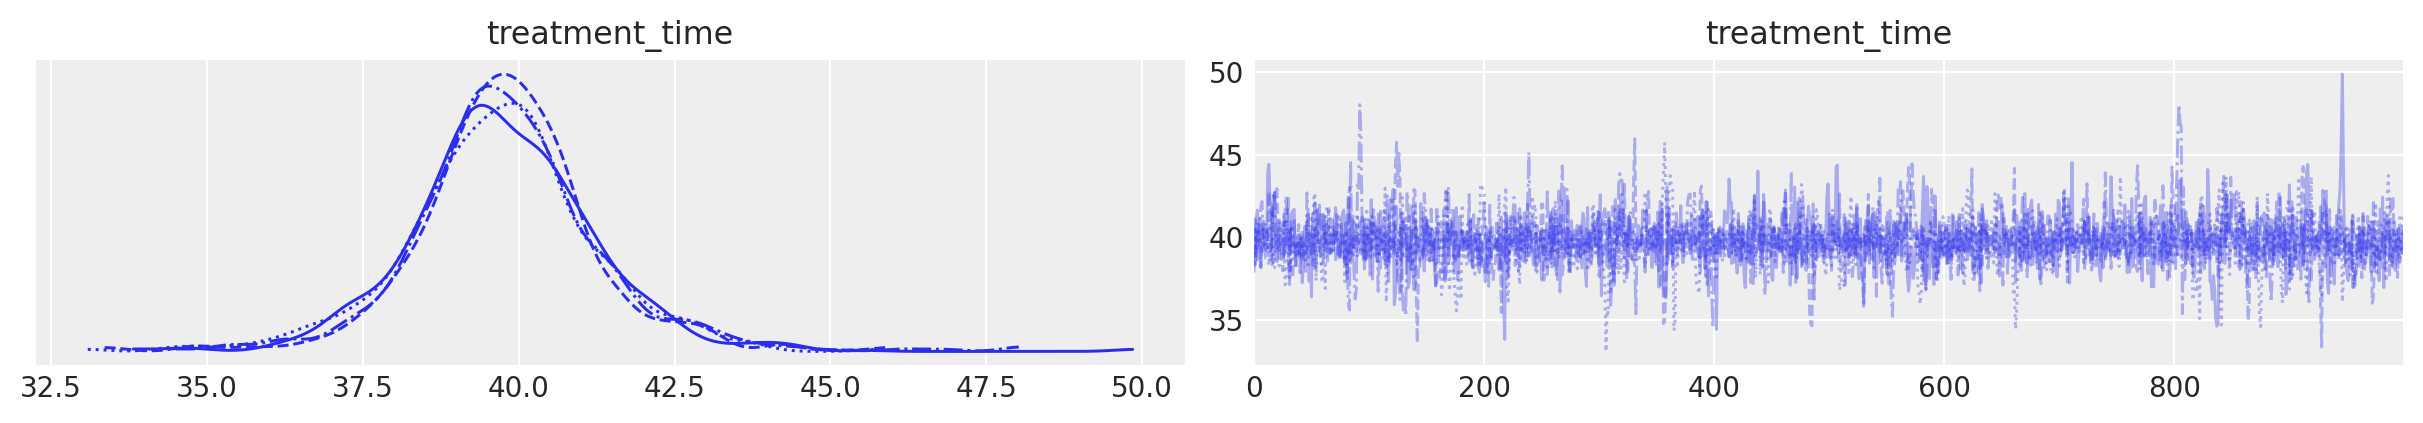

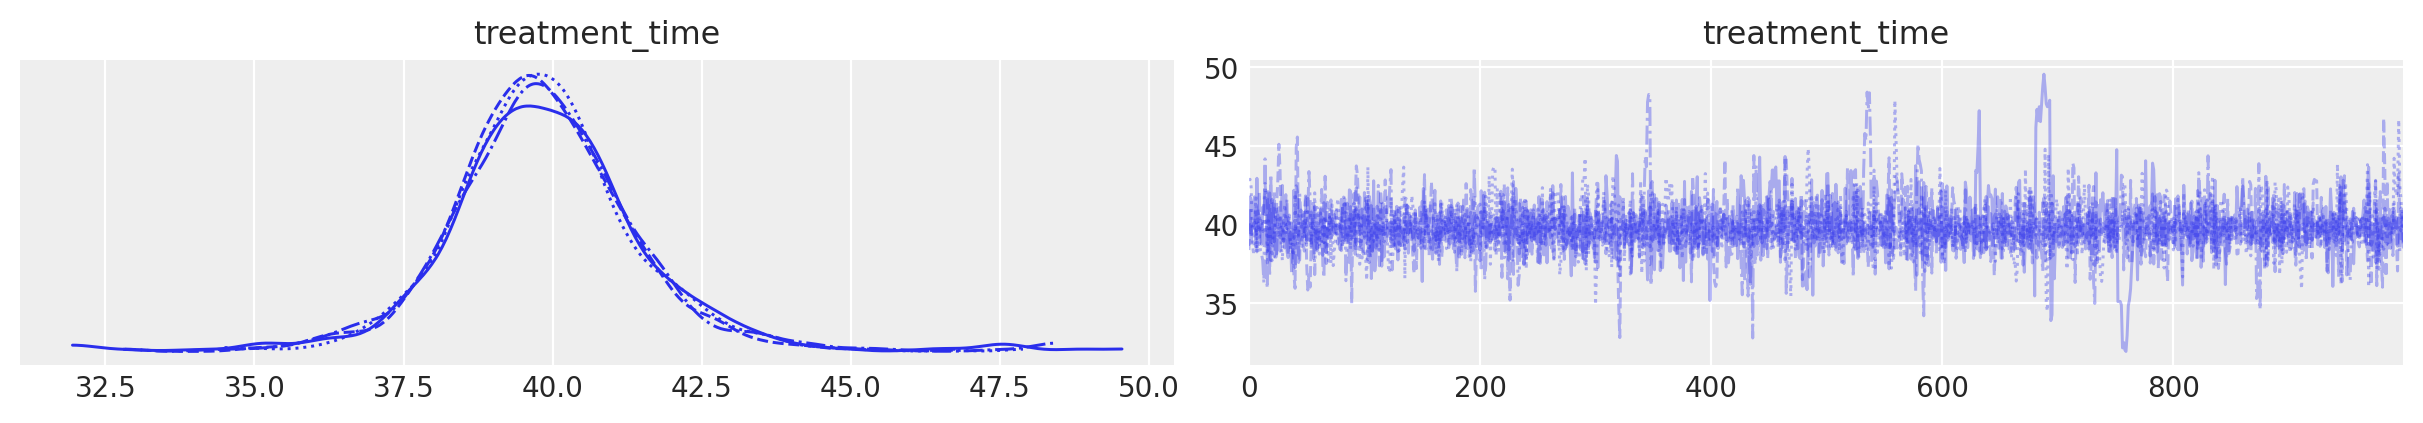

In [16]:
# First run: unconstrained treatment time — the model scans the entire time axis.
# With noisy data, this leads to a wide posterior and uncertain inference.

model = InterventionTimeEstimator(
    time_variable_name="t",
    treatment_type_effect={"level": []},
    sample_kwargs={"sample_seed": seed, "progressbar": False},
)

result = InterruptedTimeSeries(
    data=df,
    treatment_time=None,
    formula="y ~ 1 + t",
    model=model,
)

result.plot_treatment_time()

# Second run: constrain the treatment time to a plausible window (t in [20, 60]).
# This narrows the posterior, improves inference stability, and speeds up sampling.

model = InterventionTimeEstimator(
    time_variable_name="t",
    treatment_type_effect={"level": []},
    sample_kwargs={"sample_seed": seed, "progressbar": False},
)

result = InterruptedTimeSeries(
    data=df,
    treatment_time=(20, 60),
    formula="y ~ 1 + t",
    model=model,
)

result.plot_treatment_time()

#### Specifying the effect

The effects also can be specified using a dictionary passed to the `treatment_type_effect` arguments :

`model = InterventionTimeEstimator(time_variable_name="t", treatment_type_effect={"level":[], "impulse":[mu, sigma1, sigma2]})`

:::{note}
You must provide all parameters if you choose to set them manually. If you leave the list empty or not fully furnished, default priors will be used.
:::

| Effect type | Description | Parameters required |
|-------------|-------------|---------------------|
|`level`| Permanent jump in the time series level | `[mu, sigma]` for N(mu, sigma) |
|`trend`| Change in the trend slope | `[mu, sigma]` for N(mu, sigma) |
|`impulse`| Sudden change with decay | `[mu, sigma1, sigma2]` where:<br> - Amplitude ~ N(mu, sigma1)<br> - decay ~ HalfNormal(sigma2) |


### Summary: How to use ``InterventionTimeEstimator``

1. **Specify the time variable**
    
    Indicate which variable in the formula represents time using the time_variable_name argument.

2. **Select the intervention effect type**

    Choose the expected effect(s) of the intervention: "impulse", "level", or "trend".

3. **Configure priors for each effect**
    
    Either:

    - use default priors (e.g. ``treatment_type_effect={"impulse": []}``), or

    - specify custom priors (e.g. ``treatment_type_effect={"impulse": [mu, sigma1, sigma2]}``).

4. **(Optional) Limit the inference window**

    Use ``time_range=(start, end)`` to restrict inference to a specific time interval.

5. **Pass the model to InterruptedTimeSeries**

### Interrupted Time Series (InterruptedTimeSeries) : Real Data Example

In [17]:
# Load Data ...

df = (
    cp.load_data("covid")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)
df.head()

[autoreload of cutils_ext failed: Traceback (most recent call last):
  File "c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\IPython\extensions\autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\IPython\extensions\autoreload.py", line 483, in superreload
    module = reload(module)
  File "c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\importlib\__init__.py", line 128, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'cutils_ext'
]


,temp,deaths,year,month,t,pre
date,,,,,,
2006-01-01,3.8,49124,2006,1,0,True
2006-02-01,3.4,42664,2006,2,1,True
2006-03-01,3.9,49207,2006,3,2,True
2006-04-01,7.4,40645,2006,4,3,True
2006-05-01,10.7,42425,2006,5,4,True


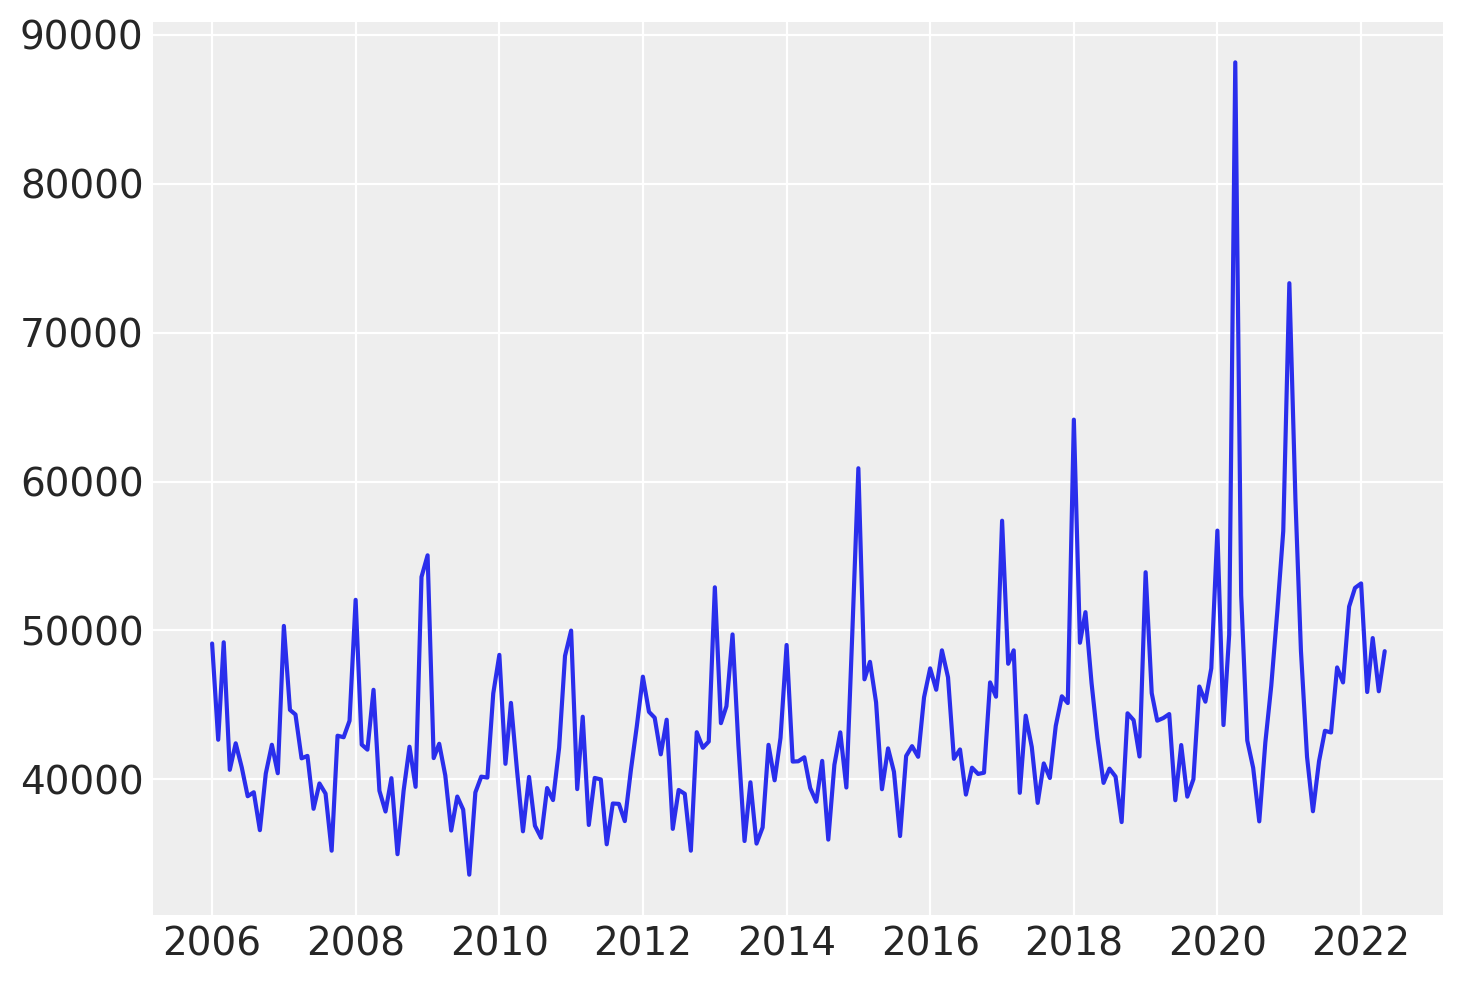

In [18]:
# Visualize the data ...

plt.plot(df.index, df["deaths"])

Looking at the data, we observe a noticeable increase in the number of deaths between years 2017 and 2019. After this period, the values seem to return to their previous level.

In this example, we will build a model using the "impulse" effect to represent this transient deviation. We won’t specify the exact location of the intervention, instead we will give a time range and hope the model will infer it from the data.

In [19]:
from causalpy.pymc_models import InterventionTimeEstimator as InterventionTimeEstimator

model = InterventionTimeEstimator(
    time_variable_name="t",
    treatment_type_effect={"impulse": []},
    sample_kwargs={"random_seed": seed, "target_accept": 0.95},
)

Run the analysis

Optionally, instead of providing a fixed `treatment_time`, we can guide the inference by specifying a time_range as a tuple, for example, restricting the intervention to occur between years 2014 and 2022. Leaving `treatment_time=None` allows the model to search freely over all possible timestamps, but adding a constraint typically speeds up inference and focuses the posterior on plausible regions.

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

In [20]:
result = InterruptedTimeSeries(
    df,
    treatment_time=(pd.to_datetime("2014-01-01"), pd.to_datetime("2022-01-01")),
    formula="standardize(deaths) ~ 0 + t + C(month) + standardize(temp)",
    model=model,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [treatment_time, beta, impulse_amplitude, decay_rate, sigma, y_hat]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.
Sampling: [beta, decay_rate, impulse_amplitude, sigma, treatment_time, y_hat, y_ts]
Sampling: [y_ts]
Sampling: [y_hat, y_ts]
Sampling: [y_hat, y_ts]


Plot the results

:::{note}

The model estimates the latent time series mu_hat by combining two components:

- `mu`: the part inferred from the user-defined formula (e.g. time + month),

- `mu_in`: the contribution from the intervention effect.

In the plots, we display only `mu` — the baseline prediction based on the formula — to better highlight the causal impact of the intervention. This makes it easier to see how the observed data diverge from what would be expected without the effect.

In contrast, evaluation metrics like R² and standard deviation are computed using `mu_hat`, which includes both the formula and the intervention effect.
As a result, R² may appear higher than what the plots suggest.
:::

[autoreload of cutils_ext failed: Traceback (most recent call last):
  File "c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\IPython\extensions\autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\IPython\extensions\autoreload.py", line 483, in superreload
    module = reload(module)
  File "c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\importlib\__init__.py", line 128, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'cutils_ext'
]


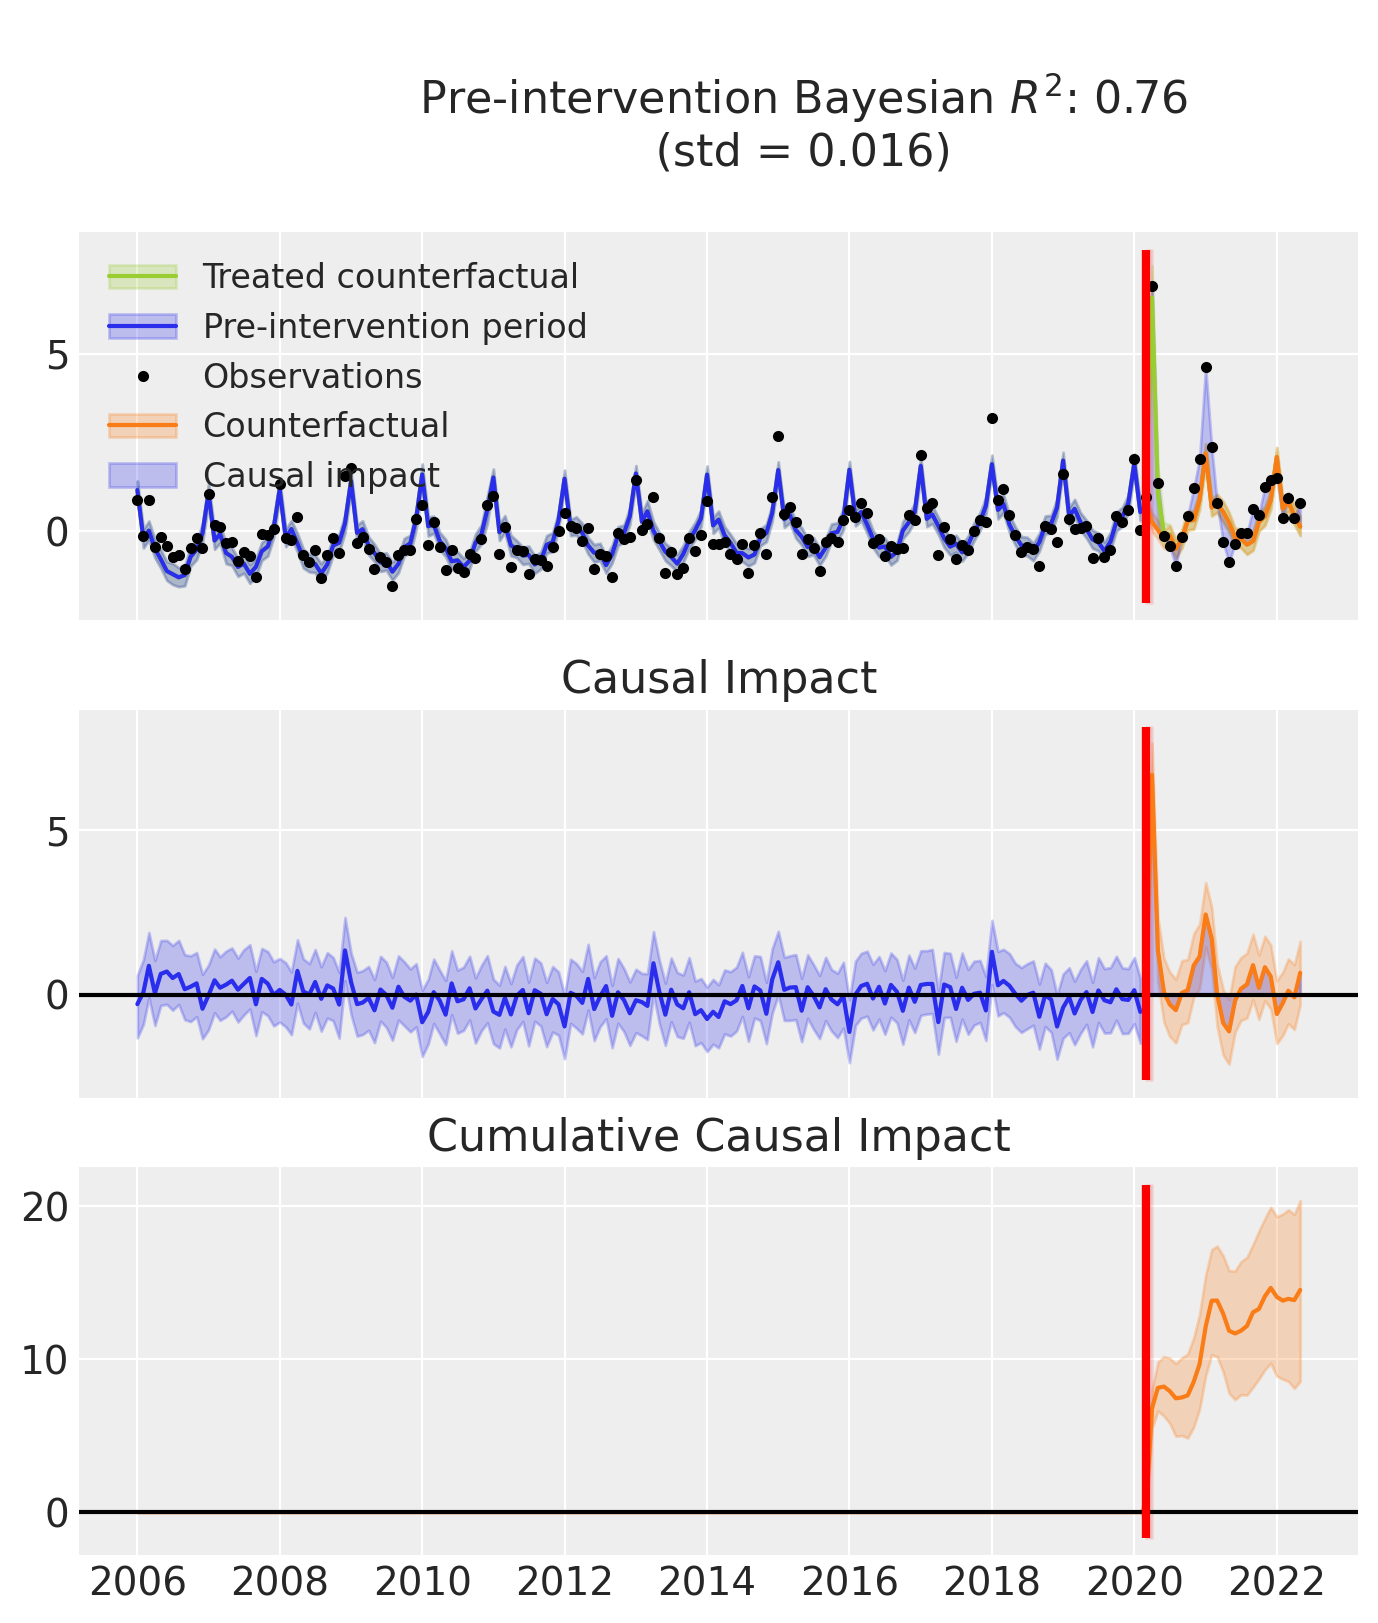

In [21]:
fig, ax = result.plot()

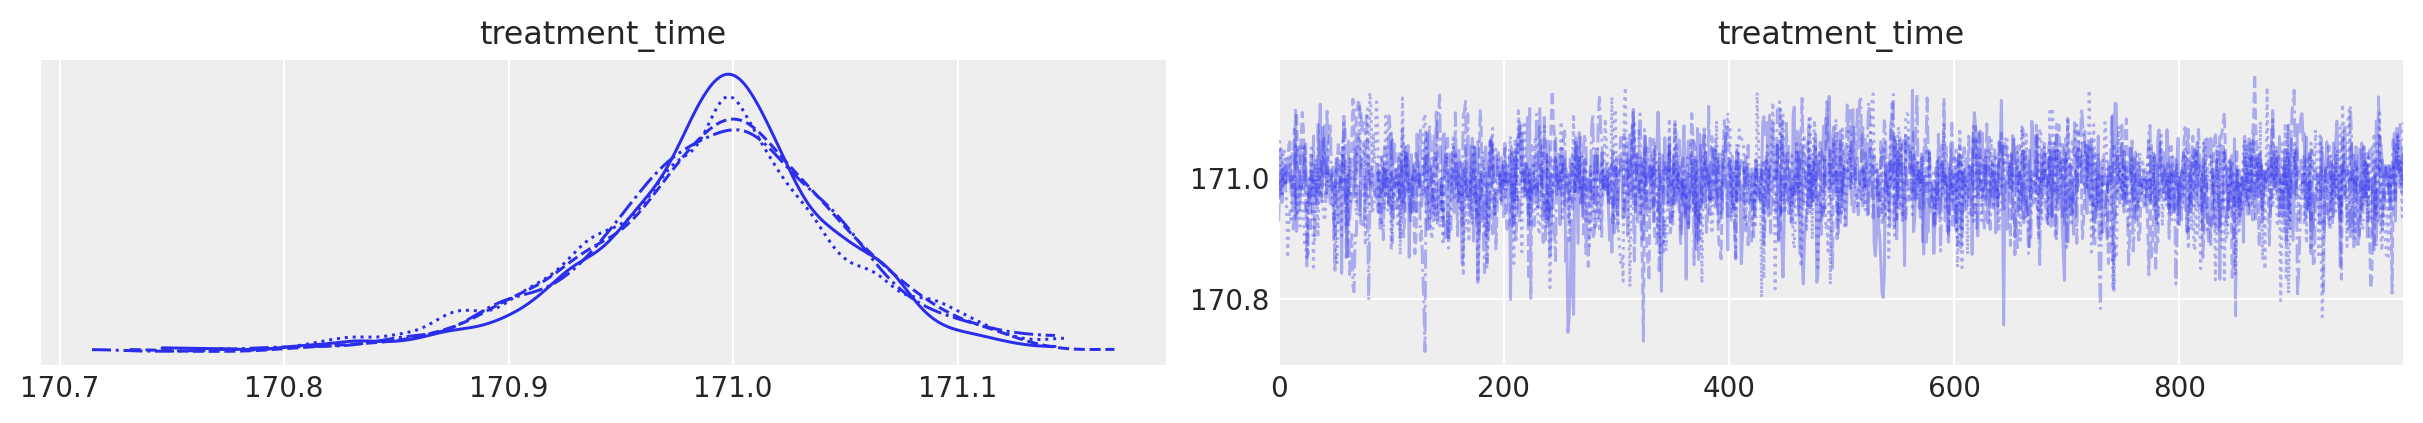

In [22]:
result.plot_treatment_time()

In [23]:
result.summary()

==================================Pre-Post Fit==================================
Formula: standardize(deaths) ~ 0 + t + C(month) + standardize(temp)
Model coefficients:
    C(month)[1]        0.79, 94% HDI [0.38, 1.2]
    C(month)[2]        -0.61, 94% HDI [-1, -0.22]
    C(month)[3]        -0.36, 94% HDI [-0.69, -0.015]
    C(month)[4]        -0.64, 94% HDI [-0.92, -0.36]
    C(month)[5]        -0.73, 94% HDI [-0.99, -0.45]
    C(month)[6]        -0.81, 94% HDI [-1.2, -0.46]
    C(month)[7]        -0.69, 94% HDI [-1.1, -0.25]
    C(month)[8]        -0.98, 94% HDI [-1.4, -0.56]
    C(month)[9]        -0.9, 94% HDI [-1.3, -0.55]
    C(month)[10]       -0.62, 94% HDI [-0.89, -0.35]
    C(month)[11]       -0.71, 94% HDI [-1, -0.42]
    C(month)[12]       -0.37, 94% HDI [-0.76, 0.013]
    t                  0.0052, 94% HDI [0.004, 0.0064]
    standardize(temp)  -0.28, 94% HDI [-0.53, -0.028]
    sigma              0.5, 94% HDI [0.45, 0.55]


As well as the model coefficients, we might be interested in the average causal impact and average cumulative causal impact.

:::{note}
Better output for the summary statistics are in progress!
:::

First we ask for summary statistics of the causal impact over the entire post-intervention period.

In [24]:
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.541,0.118,0.315,0.76,0.002,0.002,3529.0,3757.0,1.0


:::{warning}
Care must be taken with the mean impact statistic. It only makes sense to use this statistic if it looks like the intervention had a lasting (and roughly constant) effect on the outcome variable. If the effect is transient, then clearly there will be a lot of post-intervention period where the impact of the intervention has 'worn off'. If so, then it will be hard to interpret the mean impacts real meaning.
:::

We can also ask for the summary statistics of the _cumulative_ causal impact.

In [25]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,14.53,3.157,8.556,20.373,0.053,0.041,3585.0,3881.0,1.0
